Instead of working with a single image, the problems of this notebook deal with an entire dataset of small images. In particular, we will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), one of the most famous and widely used image datasets in machine learning and computer vision. It consists of 70k handwritten digits (60k for training and 10k for testing) with their corresponding labels from 0 to 9. While MNIST is far from being a challenge for modern machine learning methods (any recent classifier reaches almost perfect test accuracy on it), it is still common to find it in research papers for proof-of-concept experiments due to its simplicity and availability.

All the problems in this notebook can and should be solved using standard PyTorch tensor operations.

We start loading the typical torch packages and setting up the plotting library: 

In [1]:
%pylab inline --no-import-all

import matplotlib.pyplot as plt

import torch as th

# torchvision has a collection of common datasets available, including MNIST
from torchvision.datasets import MNIST
from torchvision.utils import make_grid  # for plotting multiple images

plt.rcParams["figure.figsize"] = (8, 8)

Populating the interactive namespace from numpy and matplotlib


Load the train and test splits of MNIST:

In [2]:
dataset_train = MNIST("./mnist", train=True, download=True)
dataset_test = MNIST("./mnist", train=False, download=True)

# The images are loaded as uint8 in the range [0, 255]. Rescale them to [0.0, 1.0]
images_train = dataset_train.data / 255.0
images_test = dataset_test.data / 255.0

targets_train = dataset_train.targets
targets_test = dataset_test.targets


The training data consists of 60000 28x28 images. We plot the first 49 training images and their corresponding labels in
a grid as an example of its contents.

torch.Size([60000, 28, 28])
tensor([[5, 0, 4, 1, 9, 2, 1],
        [3, 1, 4, 3, 5, 3, 6],
        [1, 7, 2, 8, 6, 9, 4],
        [0, 9, 1, 1, 2, 4, 3],
        [2, 7, 3, 8, 6, 9, 0],
        [5, 6, 0, 7, 6, 1, 8],
        [7, 9, 3, 9, 8, 5, 9]])


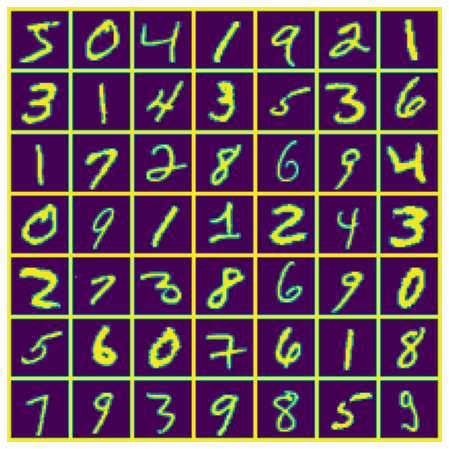

In [3]:
print(images_train.shape)
print(targets_train[:49].reshape((7, 7)))
plt.imshow(make_grid(images_train[:49, None] * 255, nrow=7, pad_value=255)[0])
plt.axis('off');

## Images as elements of $\mathbb{R}^d$

When working with images, it is sometimes convenient to consider that an image is an element of an Euclidean vector
space $\mathbb{R}^d$. Although images look like _rectangles of numbers_ and might seem to be closer to matrices than to
vectors, we can just flatten them (for example, by concatenating their rows) and express them as vectors. For
example, with the MNIST images we can do:


In [4]:
x_train = th.reshape(images_train, (images_train.shape[0], -1))
x_test = th.reshape(images_test, (images_test.shape[0], -1))
print(x_train.shape, x_test.shape)

torch.Size([60000, 784]) torch.Size([10000, 784])


In this way we can interpret the MNIST dataset as a collection of elements in the Euclidean vector space
$\mathbb{R}^{784}$ of $28\times 28 = 784$ dimensions. The advantage of doing so is that now we can transform and analyse the images using standard mathematical tools of Euclidean vector spaces. For example, we can transform the images with linear operations (i.e., matrix multiplication), project them to lower-dimensional spaces (e.g., with PCA), or we can measure the dissimilarity between two images using the inner product or a distance function.

In our case, let us focus on this last aspect of Euclidean spaces and implement the Euclidean distance as a method to measure how similar two images are. In particular, given two vectors (images) $\mathbf{x}, \mathbf{y}\in\mathbb{R}^d$, their Euclidean distance is just

$$
d(\mathbf{x}, \mathbf{y}) = \sqrt{\sum_{i=1}^d (\mathbf{x}_i - \mathbf{y}_i)^2}.
$$

For example, we can compute the Euclidean distance between the first image of the training set and the first image of the testing set as:

The Euclidean distance between img1 and img2 is 9.3953


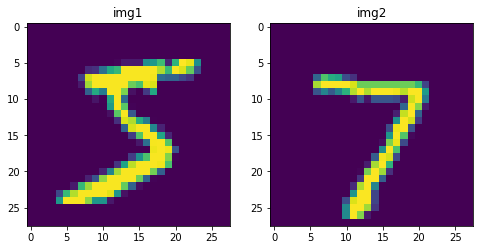

In [5]:
img1 = x_train[0]
img2 = x_test[0]
assert img1.shape == img2.shape == (28**2,)

d = th.sqrt(th.sum((img1 - img2)**2))
print(f"The Euclidean distance between img1 and img2 is {d:.4f}")
plt.subplot(1, 2, 1)
plt.imshow(img1.reshape((28, 28)))
plt.title("img1")
plt.subplot(1, 2, 2)
plt.imshow(img2.reshape((28, 28)))
plt.title("img2");

The example above computes the Euclidean distance between two individual vectors. In practice, however, we would like to compute the Euclidean distance for multiple images simultaneously. We could do so by using two nested `for` loops, but recall that Python `for` loops are not only much slower than PyTorch operations, but also cannot be parallelized in CPU or GPU as PyTorch operations do. The next question asks you to write an efficient implementation of the Euclidean distance that works for many pairs of images using standard PyTorch operations.

### <font color='orange'>Question 1</font>

Write a function `euclidean_distances` that, given two tensors `data1` and `data2` of shape `(N1, D)` and `(N2, D)`
containing `N1` and `N2` vectors of `D` dimensions, returns a tensor of shape `(N1, N2)` that contains in each element
`(i, j)` the Euclidean distance between the i-th element of `data1` and the j-th element of `data2`.

You should NOT use a `for` loop.

It is better if you annotate your functions with proper types as it was done in `part00.ipynb`.

Hint: use broadcasting.

Hint: This can be done in a single line, but it is not a requirement.


In [6]:
# small test
# data1 = th.tensor([[1,2,3],[9,9,9]])
# data2 = th.tensor([[0,2,4],[66,2,3],[8,7,0],[4,-2,1]])
# print(data1.shape)
# print(data2.shape)
# print(data1[:, np.newaxis] - data2)
# print((data1[:, np.newaxis] - data2).shape)
# print(th.sum((data1[:, np.newaxis] - data2)**2, dim=2))
# print(th.sum((data1[:, np.newaxis] - data2)**2, dim=2).shape)

In [7]:
### Solution 1
def euclidean_distances(data1: th.Tensor, data2: th.Tensor) -> th.Tensor:
    return th.sum((data1[:, np.newaxis] - data2)**2, dim=2)

___

As an example, we can use `euclidean_distances` that you implemented to find the the closest nearest image to the first three test images:

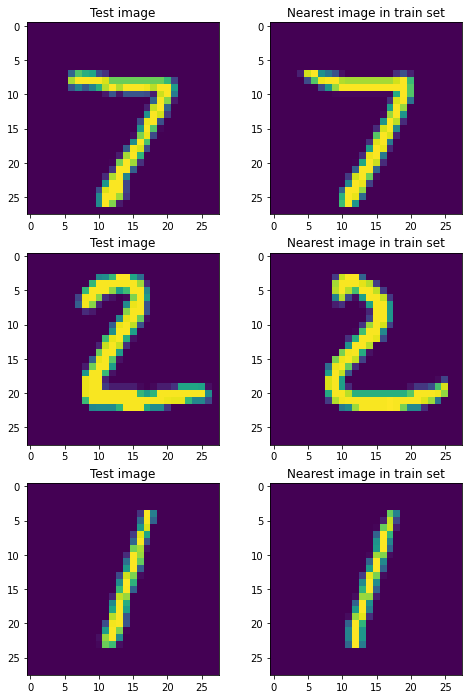

In [8]:
# Compute the distances between the first three test images and all the training images
distances = euclidean_distances(x_test[:3], x_train)
# Find the indices of training elements with minimum distances
closest_indices = distances.argmin(dim=1)
# Index the training images at the found indices
closest_x_train = x_train[closest_indices]

# Plot the test images and the corresponding nearest train images
for (ax1, ax2), test_i, train_i in zip(plt.subplots(nrows=3, ncols=2, figsize=(8, 12))[1], x_test[:3], closest_x_train):
    ax1.imshow(test_i.reshape((28, 28)))
    ax1.set_title("Test image")
    ax2.imshow(train_i.reshape((28, 28)))
    ax2.set_title("Nearest image in train set")


## k-NN classifier

In this section, we will build a simple [k-nearest neighbors classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) to classify images from the MNIST dataset. Recall that, given a query image, a k-NN classifier simply looks for the `k` most similar images in the training set and returns the most common class among the set of the `k` retrieved images. We will use the Euclidean distance as the dissimilarity measure.

### <font color='orange'>Question 2</font>

Write a function `knn_clsf` that receives a `query` tensor of shape `(N1, D)` containing the images to be classified, a `x_train` tensor of shape `(N2, D)` with the training images, a `targets_train` tensor of shape `(N2,)` with the classes of the training images, and a integer `k` indicating the number of nearest neighbors to retrieve (i.e., the k of the k-NN). `knn_clsf` should return a tensor of shape `(N1,)` where the element `i` contains the predicted class of the i-th element of `query`. The predicted class of each element should be the majority class among its `k` nearest neighbors.

Again, you should NOT use `for` loops. You can use the `euclidean_distances` function.

Hint: use `torch.mode` to extract the most common elements of a tensor. This can be implemented in 4 lines or fewer, but this is not a requirement.


In [9]:
## Solution 2
def knn_clsf(query: th.Tensor, x_train: th.Tensor, targets_train: th.Tensor, k: int) -> th.Tensor:
    query_dis = euclidean_distances(query, x_train) # compute distances between query images and training images [N1, N2]
    _, ind_knn = query_dis.topk(k, dim=1, largest=False) # find the k neighbors indexs for each query image [N1,k]
    lab_knn = targets_train[ind_knn]  # neighbor's label auto broadcast [N1,k]
    y_knn, _ = lab_knn.mode()  # Compute the most likely label [N1,]
    return y_knn

Use `knn_clsf` to classify the first 20 images of the test set. Compare the predicted classes with the
ground-truth classes in `targets_test`. How many elements were correctly classified?

In [10]:
## Solution 2
predict_label = knn_clsf(x_test[:20],x_train,targets_train,3)
print(predict_label)
print(targets_test[:20])
print((predict_label == targets_test[:20]).sum())
# as we can see from the result, if we choose k=3, all elements (=20) are corerctly classified

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])
tensor(20)


___

### <font color='orange'>Question 3</font>

According to the previous results, k-NN seems to be an excellent classifier for the MNIST dataset, and the Euclidean
distance seems to be very effective for measuring the (dis)similarity between images. However, it is a well-known fact
that both statements are false in general: the Euclidean distance is in practice a very bad method of measuring the
visual distance between images and in consequence k-NN with Euclidean distance typically performs very poorly in
computer vision problems.

Can you hypothesize why k-NN and Euclidean distance were so good for MNIST but they are so poor in more general image
datasets?


#### TODO: Write your answer here


___

Euclidean distance method is not scale in-variant which means that distances computed might be skewed depending on the units of the features. So it won't work well on not normalized data. But MNIST is a standard dataset already rescaled to [0.0, 1.0] so it is good. Besides, MNIST data's dimension is rather small that euclidean distance method can handle, but as for general large image datasets, euclidean distance end up in the curse of dimensionality .

KNN is a very simplistic and intuitive algorithm that can provide average to decent predictive power, especially when the response is dependent on the local structure of the features, like the example for MNIST. However, a major drawback of KNN is its computation time, which increases by N1 × N2 for each observation. So it's not possible to use it in large datasets